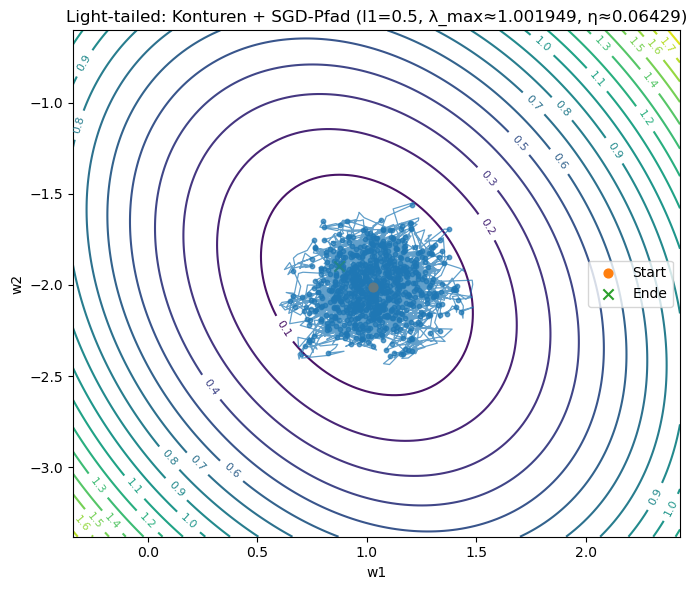

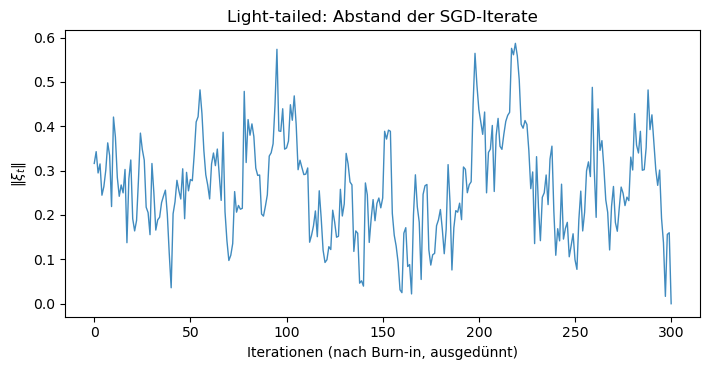

KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from αEstimator import hill_α_estimator_Bootstrap_mse  

rng = np.random.default_rng(123)

"""
Creates
"""
def make_data_curvature(n=4000, lambdas_cov=(1.0, 0.25), theta_deg=20.0, noise_std=0.8):
    Z = rng.normal(0.0, 1.0, size=(n, 2))
    s1, s2 = np.sqrt(lambdas_cov[0]), np.sqrt(lambdas_cov[1])
    S = np.diag([s1, s2])
    th = np.deg2rad(theta_deg)
    R = np.array([[np.cos(th),-np.sin(th)],
                  [np.sin(th), np.cos(th)]])
    
    X = Z @ S @ R.T
    w_true = np.array([1.0,-2.0])
    y = X @ w_true + rng.normal(0.0, noise_std, size=n)
    cov = (X.T @ X) / n
    evals, _ = np.linalg.eigh(cov)
    return X, y, evals
    
"""
Creates X with (1/n) X^T X ≈ R diag(lambdas_cov) R^T.
For MSE: H = (2/n) X^T X -> H-Eigenvalues ≈ 2 * lambdas_cov.
"""
def mse_loss(X, y, w):
    r = X @ w- y
    return np.mean(r*r)

def mse_grad_batch(Xb, yb, w):
    b = Xb.shape[0]
    r = Xb @ w - yb
    return (2.0/b) * (Xb.T @ r)

def sgd(X, y, w0, eta, batch_size, steps, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    w = w0.copy()
    ws = [w.copy()]
    ptr = 0
    order = idx.copy()
    for t in range(steps):
        if shuffle:
            if ptr + batch_size > n:
                rng.shuffle(order); ptr = 0
            bidx = order[ptr:ptr+batch_size]; ptr += batch_size
        else:
            bidx = rng.choice(idx, size=batch_size, replace=False)
        Xb, yb = X[bidx], y[bidx]
        g = mse_grad_batch(Xb, yb, w)
        w = w- eta*g
        ws.append(w.copy())
    return w, np.asarray(ws)

def hvp_full_mse(X, v):
    n = X.shape[0]
    H = (2.0/n) * (X.T @ X)
    return H @ v

def power_iter(X, tol=1e-8, maxit=10000):
    v = rng.normal(size=(2,))
    v = v / (np.linalg.norm(v) + 1e-12)
    lam_old = None
    for _ in range(maxit):
        hv = hvp_full_mse(X, v)
        lam = (v @ hv) / (v @ v + 1e-12)
        if lam_old is not None and abs(lam- lam_old) < tol:
            break
        v = hv / (np.linalg.norm(hv) + 1e-12)
        lam_old = lam
    return float(lam), v

def estimate_alpha_from_series(T_series):
    T = np.asarray(T_series, float)
    T = np.abs(T) 
    out = hill_α_estimator_Bootstrap_mse(T)
    alpha_hat = float(out[0]) if len(out) >= 1 else np.nan

    lo = float(out[2]) if len(out) >= 3 else np.nan
    hi = float(out[3]) if len(out) >= 4 else np.nan
    mse = float(out[4]) if len(out) >= 5 else np.nan
    return alpha_hat, lo, hi, mse

def plot_landscape_and_path_light(X, w_path, title, levels=22, mark_every=4):
    ws = np.asarray(w_path)
    w1_min, w1_max = ws[:,0].min(), ws[:,0].max()
    w2_min, w2_max = ws[:,1].min(), ws[:,1].max()
    pad1 = 0.5*(w1_max- w1_min + 1.0)
    pad2 = 0.5*(w2_max- w2_min + 1.0)
    W1 = np.linspace(w1_min- pad1, w1_max + pad1, 140)
    W2 = np.linspace(w2_min- pad2, w2_max + pad2, 140)
    G1, G2 = np.meshgrid(W1, W2, indexing="xy")
    L = np.zeros_like(G1)
    y_ref = X @ np.array([1.0,-2.0])
    
    for i in range(G1.shape[0]):
        for j in range(G1.shape[1]):
            wtmp = np.array([G1[i,j], G2[i,j]])
            L[i,j] = mse_loss(X, y_ref, wtmp)

    plt.figure(figsize=(7,6))
    cs = plt.contour(G1, G2, L, levels=levels)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.plot(ws[:,0], ws[:,1], linewidth=0.9, alpha=0.7)
    sel = np.arange(0, len(ws), mark_every)
    plt.scatter(ws[sel,0], ws[sel,1], s=10, alpha=0.7)
    plt.scatter([ws[0,0]],[ws[0,1]], s=40, marker='o', label='Start')
    plt.scatter([ws[-1,0]],[ws[-1,1]], s=55, marker='x', label='Ende')
    plt.xlabel("w1"); plt.ylabel("w2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def ols_slope_with_hc1(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    X = np.column_stack([np.ones_like(x), x])
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    u = y- yhat
    n, k = X.shape
    XtX_inv = np.linalg.inv(X.T @ X)
    meat = np.zeros((k,k))
    
    for i in range(n):
        xi = X[i:i+1, :]
        meat += (u[i]**2) * (xi.T @ xi)
    V_hc1 = (n/(n-k)) * (XtX_inv @ meat @ XtX_inv)
    se = np.sqrt(np.diag(V_hc1))
    slope, se_slope = beta[1], se[1]
    t_slope = slope / (se_slope + 1e-16)
    
    return beta, se_slope, t_slope

def run_experiment():
    l1_grid = [0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0,
                5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 14.0]
    l2_fixed = 0.25
    thetas = [10.0, 25.0, 45.0] 
    
    R = 4

    n = 4000; noise_std = 0.8
    b = 2; steps = 4000; burn = 0.70; thin = 4

    
    lamH_max_theory = 2.0 * max(l1_grid)
    eta_fixed = 0.9 * (2.0 / lamH_max_theory)
    results = []
    for l1 in l1_grid:
        for theta_deg in thetas:
            for r in range(R):
                _ = rng.normal()

                X, y, cov_eigs = make_data_curvature(n=n, lambdas_cov=(l1, l2_fixed), 
                                                     theta_deg=theta_deg, noise_std=noise_std)

                w_star = np.linalg.lstsq(X, y, rcond=None)[0]
                w_end, path = sgd(X, y, w_star, eta=eta_fixed, batch_size=b, steps=steps, shuffle=True)
            
                lam_max, v_max = power_iter(X, tol=1e-8)
                xi = path- w_end
                xi_used = xi[int(burn*len(xi))::thin]

                T_series = xi_used @ v_max
                
                a_hat, lo, hi, mse = estimate_alpha_from_series(T_series)
                results.append({
                    "l1": l1,
                    "theta_deg": theta_deg,
                    "lambda_max": lam_max,
                    "eta_fixed": eta_fixed,
                    "alpha_hat": a_hat,
                    "alpha_lo": lo,
                    "alpha_hi": hi
                })

    lambda_vals = np.array([r["lambda_max"] for r in results])
    alpha_vals = np.array([r["alpha_hat"] for r in results])
    lo_vals = np.array([r["alpha_lo"] for r in results])
    hi_vals = np.array([r["alpha_hi"] for r in results])

    beta, se_slope, t_slope = ols_slope_with_hc1(lambda_vals, alpha_vals)
    plt.figure(figsize=(7.8,5.4))
    plt.scatter(lambda_vals, alpha_vals, alpha=0.7, s=18)
    mask_ci = np.isfinite(lo_vals) & np.isfinite(hi_vals)
    if np.any(mask_ci):
        for x, yv, lo, hi in zip(lambda_vals[mask_ci], alpha_vals[mask_ci], lo_vals[mask_ci], hi_vals[mask_ci]):
            plt.vlines(x, lo, hi, linewidth=1)

    xgrid = np.linspace(lambda_vals.min(), lambda_vals.max(), 200)
    ygrid = beta[0] + beta[1]*xgrid
    plt.plot(xgrid, ygrid, linewidth=2)
    plt.xlabel(r'$\lambda_{\max}$')
    plt.ylabel(r'$\hat{\alpha}$ (Hill, |T|)')
    plt.title('Curvature vs Tail Index — dichtes Grid, Replikate, robuste SE')
    plt.tight_layout()
    plt.show()

def demo_light_vs_heavy():
    n = 4000; noise_std = 0.8
    b = 2; steps = 4000; burn = 0.70; thin = 4
    l2_fixed = 0.25
    theta_demo = 25.0
    l1_light = 0.5
    l1_heavy = 14.0
    lamH_max_theory = 2.0 * max(l1_light, l1_heavy)
    eta_fixed = 0.9 * (2.0 / lamH_max_theory)
    X_L, y_L, _ = make_data_curvature(n=n, lambdas_cov=(l1_light, l2_fixed), theta_deg=theta_demo, noise_std=noise_std)
    w_star_L = np.linalg.lstsq(X_L, y_L, rcond=None)[0]
    w_end_L, path_L = sgd(X_L, y_L, w_star_L, eta=eta_fixed, batch_size=b, steps=steps, shuffle=True)
    lam_L, v_L = power_iter(X_L, tol=1e-8)
    xi_L = path_L- w_end_L
    xi_used_L = xi_L[int(burn*len(xi_L))::thin]
    T_L = xi_used_L @ v_L
    plot_landscape_and_path_light(
    X_L, path_L,
    title=f"Light-tailed: Konturen + SGD-Pfad (l1={l1_light}, λ_max≈{lam_L:2f}, η≈{eta_fixed:.5f})", levels=22, mark_every=5)
    dists_L = np.linalg.norm(xi_used_L, axis=1)
    plt.figure(figsize=(7.2,3.8))
    plt.plot(dists_L, linewidth=1.0, alpha=0.85)
    plt.xlabel("Iterationen (nach Burn-in, ausgedünnt)")
    plt.ylabel(r"$\|\xi_t\|$")
    plt.title("Light-tailed: Abstand der SGD-Iterate")
    plt.tight_layout()
    plt.show()

    aL, loL, hiL, _ = estimate_alpha_from_series(T_L)
    plt.figure(figsize=(7.2,3.8))
    plt.hist(T_L, bins=50)
    plt.xlabel(r"Projektion $T_t=\langle \xi_t, v_{\max}\rangle$")
    plt.ylabel("Häufigkeit")
    plt.title(f"Light-tailed: Histogramm der Projektionen (α≈{aL:.2f}, CI≈[{loL:.2f},{hiL:.2f}])")
    plt.tight_layout()
    plt.show()
    
    X_H, y_H, _ = make_data_curvature(n=n, lambdas_cov=(l1_heavy, l2_fixed), theta_deg=theta_demo, noise_std=noise_std)
    w_star_H = np.linalg.lstsq(X_H, y_H, rcond=None)[0]
    w_end_H, path_H = sgd(X_H, y_H, w_star_H, eta=eta_fixed, batch_size=b, steps=steps, shuffle=True)
    lam_H, v_H = power_iter(X_H, tol=1e-8)
    xi_H = path_H- w_end_H
    xi_used_H = xi_H[int(burn*len(xi_H))::thin]
    T_H = xi_used_H @ v_H
    plot_landscape_and_path_light(X_H, path_H, title=f"Heavy-tailed: Konturen + SGD-Pfad (l1={l1_heavy}, λ_max≈{lam_H:.2f}, η≈{eta_fixed:.5f})", levels=22, mark_every=5
    )

    dists_H = np.linalg.norm(xi_used_H, axis=1)
    plt.figure(figsize=(7.2,3.8))
    plt.plot(dists_H, linewidth=1.0, alpha=0.85)
    plt.xlabel("Iterationen (nach Burn-in, ausgedünnt)")
    plt.ylabel(r"$\|\xi_t\|$")
    plt.title("Heavy-tailed: Abstand der SGD-Iterate")
    plt.tight_layout()
    plt.show()
    aH, loH, hiH, _ = estimate_alpha_from_series(T_H)
    plt.figure(figsize=(7.2,3.8))
    plt.hist(T_H, bins=50)
    plt.xlabel(r"Projektion $T_t=\langle \xi_t, v_{\max}\rangle$")
    plt.ylabel("Häufigkeit")
    plt.title(f"Heavy-tailed: Histogramm der Projektionen (α≈{aH:.2f}, CI≈[{loH:.2f},{hiH:.2f}])")
    plt.tight_layout()
    plt.show()

    print("\n[Demo-Zusammenfassung]")
    print(f" Light-tailed: λ_max≈{lam_L:.3f}, α(|T|)≈{aL:.2f} (CI≈[{loL:.2f},{hiL:.2f}])")

    print(f" Heavy-tailed: λ_max≈{lam_H:.3f}, α(|T|)≈{aH:.2f} (CI≈[{loH:.2f},{hiH:.2f}])")

if __name__ == "__main__":
    demo_light_vs_heavy()
    run_experiment()